# Minimax Optimization

In [1]:
import argparse
import copy
import typing

import higher
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


class Encoder(nn.Module):
    def __init__(self, z_dim=2):
        super().__init__()
        self.module = nn.Sequential(
            nn.Linear(784, 1024), nn.ReLU(inplace=True), nn.Linear(1024, z_dim),
        )

    def forward(self, x):
        return self.module(torch.flatten(x, start_dim=1))


class Q(nn.Module):
    def __init__(self, z_dim=2, n_cls: int = 10):
        super().__init__()
        self.module = nn.Sequential(
            nn.Linear(z_dim, 4048), nn.ReLU(inplace=True), nn.Linear(4048, n_cls),
        )

    def forward(self, z):
        return self.module(z)


class Qminus(nn.Module):
    def __init__(self, z_dim=2, n_cls: int = 10):
        super().__init__()
        self.module = nn.Sequential(nn.Linear(z_dim, n_cls))

    def forward(self, z):
        return self.module(z)


class DIB(nn.Module):
   

    def __init__(
        self,
        is_small_adv: bool = True,
        n_cls: int = 10,
        n_inner_iter: int = 5,
        is_adv: bool = True,
        beta: int = 1,
        gamma: int = 1,
        is_higher: bool = True,
        is_load=True,
        z_dim=2,
        is_single_opt=False
    ):
        super().__init__()
        if is_small_adv:
            self.q, self.q_adv = (
                Q(z_dim=z_dim, n_cls=n_cls),
                Qminus(z_dim=z_dim, n_cls=n_cls),
            )
        else:
            self.q_adv, self.q = (
                Q(z_dim=z_dim, n_cls=n_cls),
                Qminus(z_dim=z_dim, n_cls=n_cls),
            )

        self.n_cls = n_cls
        self._n_inner_iter = n_inner_iter
        self.is_adv = is_adv
        self.beta = beta
        self.gamma = gamma
        self.is_higher = is_higher
        self.is_load = is_load
        self.is_single_opt = is_single_opt
        
        if self.is_single_opt:
            self.inner_opt = torch.optim.Adam(self.q_adv.parameters(), lr=1e-3)

    @property
    def n_inner_iter(self):
        return self._n_inner_iter if self.training else 1000

    def forward(self, z, y):

        loss_clf = F.cross_entropy(self.q(z), y)

        if not self.training:
            q_adv_old = self.q_adv
            self.q_adv = copy.deepcopy(self.q_adv)

        if self.is_higher and self.training:
            self.train_heads_higher(z, y)
        else:
            self.train_heads_freeze(z, y)

        pred_adv = self.q_adv(z)
        loss_enc = F.cross_entropy(pred_adv, y)

        if not self.training:
            self.q_adv = q_adv_old

        if self.is_adv:
            loss_enc = -loss_enc

        return self.beta * loss_clf, self.gamma * loss_enc, self.q(z), pred_adv

    def train_heads_higher_old(self, z, y):

        # Define a differentiable optimizer to update the label with.
        inner_opt = higher.get_diff_optim(
            torch.optim.Adam(self.q_adv.parameters(), lr=1e-3), self.q_adv.parameters()
        )

        # Take a few gradient steps to find good heads
        for _ in range(self.n_inner_iter):
            loss_adv = F.cross_entropy(self.q_adv(z), y)
            inner_opt.step(loss_adv, params=self.q_adv.parameters())

    def train_heads_higher(self, z, y):

        inner_opt = torch.optim.Adam(self.q_adv.parameters(), lr=1e-3)
        with higher.innerloop_ctx(
            self.q_adv,
            inner_opt,
            copy_initial_weights=False,
            track_higher_grads=self.training,
        ) as (fnet, diffopt):

            # Take a few gradient steps to find good heads
            for _ in range(self.n_inner_iter):
                loss_adv = F.cross_entropy(fnet(z), y)
                diffopt.step(loss_adv)

            if self.is_load:
                self.q_adv.load_state_dict(fnet.state_dict())

    def train_heads_freeze(self, z, y):

        z = z.detach()  # don't backprop through encoder
        inner_opt = torch.optim.Adam(self.q_adv.parameters(), lr=1e-3)

        def closure():
            inner_opt.zero_grad()
            loss_adv = F.cross_entropy(self.q_adv(z), y)
            loss_adv.backward()
            return loss_adv

        for i in range(self.n_inner_iter):
            inner_opt.step(closure)


class ERM(nn.Module):
    def __init__(
        self, *args, n_cls: int = 10, z_dim=2, **kwargs,
    ):
        super().__init__()

        self.q = Qminus(n_cls)
        self.q_adv = self.q

    def forward(self, z, y):

        loss_clf = F.cross_entropy(self.q(z), y)

        return loss_clf, 0 * loss_clf


def train(model, criterion, device, train_loader, optimizer, epoch, log_interval=20):

    model.train()
    criterion.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        z = model(data)
        loss_clf, loss_enc, _, _ = criterion(z, target)
        (loss_clf + loss_enc).backward()
        optimizer.step()

        if log_interval != 0 and batch_idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss Q: {:.6f}\tLoss Q adv: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss_clf.item(),
                    loss_enc.item(),
                )
            )


def test(model, criterion, device, test_loader, epoch):
    """Evaluate the performance on the test dataset."""
    model.eval()
    criterion.eval()
    test_loss_adv = 0
    test_loss_q = 0
    correct_q = 0
    correct_adv = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        z = model(data)
        loss_clf, loss_enc, pred_q, pred_adv = criterion(z, target)
        test_loss_adv -= loss_enc.sum().item()
        test_loss_q += loss_clf.sum().item()
        pred_q = pred_q.argmax(dim=1, keepdim=True)
        pred_adv = pred_adv.argmax(dim=1, keepdim=True)
        correct_q += pred_q.eq(target.view_as(pred_q)).sum().item()
        correct_adv += pred_adv.eq(target.view_as(pred_adv)).sum().item()

    test_loss_adv /= len(test_loader.dataset)
    test_loss_q /= len(test_loader.dataset)

    print(
        "\nTesting in Epoch {}: Average loss: q={:.8f}; adv={:.8f}  \t Accuracy Q : {:.2f}% \t Accuracy Adv : {:.2f}%\n".format(
            epoch,
            test_loss_q,
            test_loss_adv,
            100.0 * correct_q / len(test_loader.dataset),
            100.0 * correct_adv / len(test_loader.dataset),
        )
    )

In [12]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

n_train = 5000
n_test = 1000
idcs_train = list(range(n_train))
np.random.shuffle(idcs_train)


def get_train_data_loader(batch_size):
    return DataLoader(
        datasets.MNIST(
            "/tmp/mnist-data",
            train=True,
            download=True,
            transform=transforms.Compose(
                [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
            ),
        ),
        batch_size=batch_size,
    )


train_loader = get_train_data_loader(256)
test_loader = get_train_data_loader(4096)


device = torch.device("cuda")

## `is_load`
Effect of loading the inner module vs restarting

In [3]:
for is_load in [True, False]:
    print("is_load:", is_load)

    z_dim = 10
    encoder = Encoder(z_dim=z_dim).to(device)
    criterion = DIB(n_inner_iter=10, is_higher=True, z_dim=z_dim, is_load=is_load).to(
        device
    )
    optimizer = optim.Adam(
        list(encoder.parameters()) + list(criterion.q.parameters()), lr=3e-4
    )

    for epoch in range(5):
        train(
            encoder, criterion, device, train_loader, optimizer, epoch, log_interval=0
        )

    test(encoder, criterion, device, test_loader, epoch)

    encoder.to(torch.device("cpu"))
    criterion.to(torch.device("cpu"))

is_load: True

Testing in Epoch 4: Average loss: q=0.00013010; adv=0.00011968  	 Accuracy Q : 86.58% 	 Accuracy Adv : 85.07%

is_load: False

Testing in Epoch 4: Average loss: q=0.66131139; adv=0.03873382  	 Accuracy Q : 15.49% 	 Accuracy Adv : 2.06%



## `z_dim`
Effect of dimensionality of z

In [6]:
for z_dim in [2, 4, 8, 128, 1024]:
    print("z_dim:", z_dim)

    encoder = Encoder(z_dim=z_dim).to(device)
    criterion = DIB(n_inner_iter=10, is_higher=True, z_dim=z_dim, is_load=True).to(
        device
    )
    optimizer = optim.Adam(
        list(encoder.parameters()) + list(criterion.q.parameters()), lr=3e-4
    )

    for epoch in range(5):
        train(
            encoder, criterion, device, train_loader, optimizer, epoch, log_interval=0
        )

    test(encoder, criterion, device, test_loader, epoch)

    encoder.to(torch.device("cpu"))
    criterion.to(torch.device("cpu"))

z_dim: 2

Testing in Epoch 4: Average loss: q=0.00021608; adv=0.00054495  	 Accuracy Q : 73.64% 	 Accuracy Adv : 30.67%

z_dim: 4

Testing in Epoch 4: Average loss: q=0.00078564; adv=0.00013315  	 Accuracy Q : 77.24% 	 Accuracy Adv : 84.41%

z_dim: 8

Testing in Epoch 4: Average loss: q=0.00009704; adv=0.00046859  	 Accuracy Q : 87.64% 	 Accuracy Adv : 35.44%

z_dim: 128

Testing in Epoch 4: Average loss: q=0.00008146; adv=0.00005935  	 Accuracy Q : 89.39% 	 Accuracy Adv : 93.23%

z_dim: 1024

Testing in Epoch 4: Average loss: q=0.00069846; adv=0.00112772  	 Accuracy Q : 54.63% 	 Accuracy Adv : 83.44%



## `is_higher`
backprop in optimization or not

In [7]:
for is_higher in [True, False]:
    print("is_higher:", is_higher)

    z_dim = 10
    encoder = Encoder(z_dim=z_dim).to(device)
    criterion = DIB(is_adv=True, n_inner_iter=10, is_higher=is_higher, z_dim=z_dim).to(
        device
    )
    optimizer = optim.Adam(
        list(encoder.parameters()) + list(criterion.q.parameters()), lr=3e-4
    )

    for epoch in range(5):
        train(
            encoder, criterion, device, train_loader, optimizer, epoch, log_interval=0
        )

    test(encoder, criterion, device, test_loader, epoch)

    encoder.to(torch.device("cpu"))
    criterion.to(torch.device("cpu"))

is_higher: True

Testing in Epoch 4: Average loss: q=0.00009625; adv=0.00043195  	 Accuracy Q : 88.99% 	 Accuracy Adv : 43.88%

is_higher: False

Testing in Epoch 4: Average loss: q=0.00015368; adv=0.00037276  	 Accuracy Q : 82.59% 	 Accuracy Adv : 49.93%



## `n_inner_iter`
Effect of inner optimization steps

In [9]:
for n_inner_iter in [2, 10, 100]:
    print("n_inner_iter:", n_inner_iter)

    z_dim = 10
    encoder = Encoder(z_dim=z_dim).to(device)
    criterion = DIB(
        n_inner_iter=n_inner_iter, is_higher=True, z_dim=z_dim, is_load=True
    ).to(device)
    optimizer = optim.Adam(
        list(encoder.parameters()) + list(criterion.q.parameters()), lr=3e-4
    )

    for epoch in range(5):
        train(
            encoder, criterion, device, train_loader, optimizer, epoch, log_interval=0
        )

    test(encoder, criterion, device, test_loader, epoch)

    encoder.to(torch.device("cpu"))
    criterion.to(torch.device("cpu"))

n_inner_iter: 2

Testing in Epoch 4: Average loss: q=0.00013499; adv=0.00009040  	 Accuracy Q : 90.72% 	 Accuracy Adv : 89.28%

n_inner_iter: 10

Testing in Epoch 4: Average loss: q=0.00029147; adv=0.00022898  	 Accuracy Q : 77.12% 	 Accuracy Adv : 70.35%

n_inner_iter: 100

Testing in Epoch 4: Average loss: q=0.00002769; adv=0.00055824  	 Accuracy Q : 96.93% 	 Accuracy Adv : 26.43%



## `batch_size`
Effect of batch size

**on train**

In [14]:
for batch_size in [64,256,1024,4096]:
    print("batch_size:", batch_size)

    z_dim = 10
    encoder = Encoder(z_dim=z_dim).to(device)
    criterion = DIB(
        n_inner_iter=100, is_higher=True, z_dim=z_dim, is_load=True
    ).to(device)
    optimizer = optim.Adam(
        list(encoder.parameters()) + list(criterion.q.parameters()), lr=3e-4
    )

    for epoch in range(5):
        train(
            encoder, criterion, device, get_train_data_loader(batch_size), optimizer, epoch, log_interval=0
        )

    test(encoder, criterion, device, test_loader, epoch)

    encoder.to(torch.device("cpu"))
    criterion.to(torch.device("cpu"))

batch_size: 64

Testing in Epoch 4: Average loss: q=0.00007423; adv=0.00051259  	 Accuracy Q : 92.00% 	 Accuracy Adv : 27.89%

batch_size: 256

Testing in Epoch 4: Average loss: q=0.00002989; adv=0.00055338  	 Accuracy Q : 96.61% 	 Accuracy Adv : 24.83%

batch_size: 1024

Testing in Epoch 4: Average loss: q=0.00010344; adv=0.00053473  	 Accuracy Q : 88.70% 	 Accuracy Adv : 28.86%

batch_size: 4096

Testing in Epoch 4: Average loss: q=0.00017944; adv=0.00017987  	 Accuracy Q : 76.36% 	 Accuracy Adv : 76.94%



**on test**

In [15]:
encoder.to(device)
criterion.to(device)

for batch_size in [64,256,1024,4096]:
    print("batch_size:", batch_size)
    test(encoder, criterion, device, get_train_data_loader(batch_size), epoch)

batch_size: 64

Testing in Epoch 4: Average loss: q=0.01127896; adv=0.00428821  	 Accuracy Q : 76.36% 	 Accuracy Adv : 94.06%

batch_size: 256

Testing in Epoch 4: Average loss: q=0.00282493; adv=0.00210018  	 Accuracy Q : 76.36% 	 Accuracy Adv : 82.94%

batch_size: 1024

Testing in Epoch 4: Average loss: q=0.00070806; adv=0.00066659  	 Accuracy Q : 76.36% 	 Accuracy Adv : 78.20%

batch_size: 4096

Testing in Epoch 4: Average loss: q=0.00017944; adv=0.00017987  	 Accuracy Q : 76.36% 	 Accuracy Adv : 76.94%



In [16]:
for batch_size in [64,256,1024,4096]:
    print("batch_size:", batch_size)

    z_dim = 10
    encoder = Encoder(z_dim=z_dim).to(device)
    criterion = DIB(
        n_inner_iter=10, is_higher=True, z_dim=z_dim, is_load=True
    ).to(device)
    optimizer = optim.Adam(
        list(encoder.parameters()) + list(criterion.q.parameters()), lr=3e-4
    )

    for epoch in range(5):
        train(
            encoder, criterion, device, get_train_data_loader(batch_size), optimizer, epoch, log_interval=0
        )

    test(encoder, criterion, device, test_loader, epoch)

    encoder.to(torch.device("cpu"))
    criterion.to(torch.device("cpu"))

batch_size: 64

Testing in Epoch 4: Average loss: q=0.00022767; adv=0.00036803  	 Accuracy Q : 81.67% 	 Accuracy Adv : 50.72%

batch_size: 256

Testing in Epoch 4: Average loss: q=0.00027189; adv=0.00020321  	 Accuracy Q : 76.57% 	 Accuracy Adv : 73.23%

batch_size: 1024

Testing in Epoch 4: Average loss: q=0.00021287; adv=0.00021211  	 Accuracy Q : 75.14% 	 Accuracy Adv : 77.05%

batch_size: 4096

Testing in Epoch 4: Average loss: q=0.00012790; adv=0.00012246  	 Accuracy Q : 86.91% 	 Accuracy Adv : 87.30%



In [484]:
t=torch.rand(2,3,4,5,6,7)

In [ ]:
t.view(*t.shape[2:])

In [496]:
import numpy as np
np.arange(5)+1

array([1, 2, 3, 4, 5])

In [489]:
class LogCumsumExp(function.Function):

    def check_type_forward(self, in_types):
        type_check.expect(
            in_types.size() == 1,
            in_types[0].dtype.kind == 'f',
        )

    def forward(self, inputs):
        xp = cuda.get_array_module(*inputs)

        x, = inputs
        m = x.max(axis=0, keepdims=True)
        y = x - m
        xp.exp(y, out=y)
        y_sum = xp.flip(xp.cumsum(xp.flip(y, axis=0)), axis=0)
        self.y = xp.transpose(xp.asarray(xp.log(y_sum) + m))
        return self.y,

torch.Size([2, 3])

In [512]:
def log_cumsum_exp(x, dim):
    m = x.max(axis=0, keepdims=True)[0]
    y = torch.exp(x - m)
    y_sum = torch.flip(torch.cumsum(torch.flip(y, 0)), 0)
    return torch.log(y_sum) + m

In [516]:
def logcumsumexp(x, dim):
    # slow implementation, but ok for now
    if (dim != -1) or (dim != x.ndimension() - 1):
        x = x.transpose(dim, -1)

    out = []
    for i in range(1, x.size(-1) + 1):
        out.append(torch.logsumexp(x[..., :i], dim=-1, keepdim=True))
    out = torch.cat(out, dim=-1)

    if (dim != -1) or (dim != x.ndimension() - 1):
        out = out.transpose(-1, dim)
    return out

In [ ]:
logcumsumexp(x, dim)

In [519]:
torch.arange(5)

tensor([0, 1, 2, 3, 4])

In [525]:
(torch.rand(5,3) - torch.rand(5,1)).shape

torch.Size([5, 3])

In [522]:
t.shape

torch.Size([2, 3, 4])

In [521]:
torch.cumsum(t,1).shape

torch.Size([2, 3, 4])

In [501]:
t = torch.rand(2,3,4)

In [506]:
logcumsumexp(t.log(),1).mean()

tensor(-0.3446)

In [503]:
def cummax(x, dim):
    x_np = x.detach().cpu().numpy()
    ret = np.maximum.accumulate(x_np, axis=dim)
    return torch.from_numpy(ret).to(x)


def logcumsumexp(x, dim=-1):
    if (dim != -1) or (dim != x.ndimension() - 1):
        x = x.transpose(dim, -1)

    init_size = x.size()
    last_dim_size = init_size[-1]
    x_resized = x.contiguous().view(-1, last_dim_size)
    d1, d2 = x_resized.size()
    x_cummax = cummax(x_resized, -1).view(d1, d2, 1)
    x_expand = x_resized.unsqueeze(1).expand(d1, d2, last_dim_size)
    mask = torch.tril(torch.ones(last_dim_size, last_dim_size)).unsqueeze(0)
    ret = torch.log(torch.sum(torch.exp(x_expand - x_cummax) * mask, dim=-1)) + x_cummax.view(d1, d2)
    ret = ret.view(*init_size)

    if (dim != -1) or (dim != x.ndimension() - 1):
        ret = ret.transpose(-1, dim)

    return ret

tensor(-0.3446)

In [186]:
a=np.array([0,1,2,3])
a[np.array(a%2 == 0)]

array([0, 2])

In [463]:
from scipy.stats import rv_discrete

class LightTailPareto(rv_discrete):
    def _cdf(self, k, alpha):
        # alpha is factor like in SUMO paper
        # m is minimum number of samples
        m = self.a # lower bound of support
        
        # in the paper they us P(K >= k) but cdf is P(K <= k) = 1 - P(K > k) = 1 - P(K >= k + 1)
        k = k + 1
        
        # make sure has at least m samples
        k = np.clip(k - m, a_min=1, a_max=None) # makes sure no division by 0
        alpha = alpha - m
        
        # sample using pmf 1/k but with finite expectation
        cdf = 1 - np.where(k < alpha, 1/k, (1/alpha) * (0.9)**(k-alpha))
        
        return cdf
        

In [479]:
dist = LightTailPareto(a=3).freeze(80)

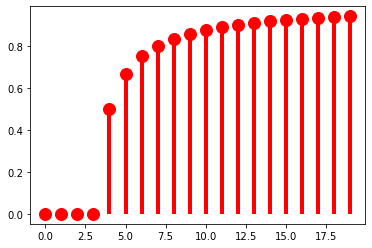

In [480]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
xk = np.arange(20)
ax.plot(xk, dist.cdf(xk), 'ro', ms=12, mec='r')
ax.vlines(xk, 0, dist.cdf(xk), colors='r', lw=4)
plt.show()

In [466]:
dist.rvs()

11

In [467]:
1-dist.cdf(7)

0.19999999999999996

In [468]:
dist.support()[0]

3

In [475]:
a=1

In [ ]:
torch.nn.Parameters

In [526]:
1 - dist.cdf()

In [1]:
cd ..

/private/home/yannd/projects/Decodable_Information_Bottleneck


In [2]:
import torch 
from utils.data.imgs import get_Dataset
from utils.data.helpers import get_mean_std

In [3]:
cifar10 = get_Dataset("cifar10")(split="train")

Files already downloaded and verified


In [535]:
get_mean_std(cifar10)

(array([0.4914009 , 0.48215896, 0.4465308 ], dtype=float32),
 array([0.24703279, 0.24348423, 0.26158753], dtype=float32))

In [11]:
ls ../tmp_results/corrResnets/data_svhn/datasize_all/augment_False/rand_False/schedule_decay/optim_adam/lr_5e-05/chckpnt_last/wdecay_0/model_erm/dropout_0/encoder_resnet34/enc_zy_nhid_128/enc_zy_nlay_2/enc_zy_kpru_0/enc_zx_nhid_128/enc_zx_nlay_2/enc_zx_kpru_0/beta_1/nskip_0/zdim_1024/minimax_0/mchead_3/clfs_default/run_0/

clf_nhid_128/  transformer/


In [8]:
import glob

files = glob.glob("../tmp_results/corrResnets/**/clf_nhid*/", recursive=True)

In [13]:
import shutil
for f in files:
    shutil.rmtree(f) 

In [14]:
def get_idx_permuter(n_idcs, seed=123):
    """Return permuted indices.
    
    Paramaters
    ----------
    n_idcs : int or array-like of int
        Number of indices. If list, it should be a partion of the real number of idcs.
        Each partition will be permuted separately.
        
    seed : int, optional
    """

    if isinstance(n_idcs, int):
        idcs = list(range(n_idcs))
    else:
        idcs = [list(range(partition)) for partition in n_idcs]

    with tmp_seed(seed):
        if isinstance(n_idcs, int):
            random.shuffle(idcs)
            idcs = torch.tensor(idcs)

        else:

            # shuffle each partition separetly
            for partition_idcs in idcs:
                random.shuffle(partition_idcs)

            idcs = torch.cat([torch.tensor(idcs) for idcs in idcs])

    return idcs

In [20]:
ls

add_hyperparam.py  LICENSE         __pycache__/        results_old/
aggregate.py       load_models.py  README.md           tensorboard/
bin/               main.py         requirements_fb.sh  tmp_results/
conf/              notebooks/      requirements.txt    utils/
dib/               outputs/        results/


In [21]:
from dib.utils.helpers import get_idx_permuter
_rand_indcs = get_idx_permuter([3,6,9], seed=123)

In [22]:
_rand_indcs

tensor([2, 1, 0, 1, 4, 5, 2, 3, 0, 7, 8, 3, 4, 1, 0, 2, 5, 6])